In [1]:
# import necessary Python packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

#from sklearn.ensemble import IsolationForest
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler, StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings("ignore")


mpl.rcParams['figure.figsize']= (10,8)
mpl.rcParams['axes.grid']= False

In [2]:
edata = pd.read_csv('energydata.csv')

In [3]:
edata['date']= pd.to_datetime(edata['date'])

In [4]:
edata= edata.set_index('date').resample('H').mean().reset_index() #aggregating into hourly basis

In [5]:
#edata['hour']= edata.date.dt.hour
#edata['Year']= edata['date'].dt.year
#edata['month'] = edata['date'].dt.month

In [6]:
#edata['weekday']= pd.Categorical(edata.date.dt.strftime('%A'), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

In [8]:
edata.head()

,date,appl,lgt,temp1,rh_1,temp2,rh_2,temp3,rh_3,temp4,...,temp9,rh_9,temp_out,press,rh_out,windspeed,visibility,dewpoint,rv1,rv2
0,2016-01-11 17:00:00,55.000000,35.000000,19.890000,46.502778,19.200000,44.626528,19.790000,44.897778,18.932778,...,17.016667,45.446667,6.308333,733.750000,92.000000,6.166667,53.416667,5.050000,26.823044,26.823044
1,2016-01-11 18:00:00,176.666667,51.666667,19.897778,45.879028,19.268889,44.438889,19.770000,44.863333,18.908333,...,16.981667,45.290000,5.941667,734.266667,91.583333,5.416667,40.000000,4.658333,22.324206,22.324206
2,2016-01-11 19:00:00,173.333333,25.000000,20.495556,52.805556,19.925556,46.061667,20.052222,47.227361,18.969444,...,16.902222,45.311389,6.000000,734.791667,89.750000,6.000000,40.000000,4.391667,33.734932,33.734932
3,2016-01-11 20:00:00,125.000000,35.000000,20.961111,48.453333,20.251111,45.632639,20.213889,47.268889,19.190833,...,16.890000,45.118889,6.000000,735.283333,87.583333,6.000000,40.000000,4.016667,25.679642,25.679642
4,2016-01-11 21:00:00,103.333333,23.333333,21.311667,45.768333,20.587778,44.961111,20.373333,46.164444,19.425556,...,16.890000,44.807778,5.833333,735.566667,87.416667,6.000000,40.000000,3.816667,18.826274,18.826274


In [ ]:
#edata= edata.set_index('date').resample('D').mean().reset_index() #aggregating into hourly basis

In [5]:
#converting dataframe into index
edata.set_index('date', inplace=True)

In [10]:
#edata.to_csv('energydataex.csv', index=False) #excluding the index
#edata.to_csv('energydataexindex.csv') #including the index

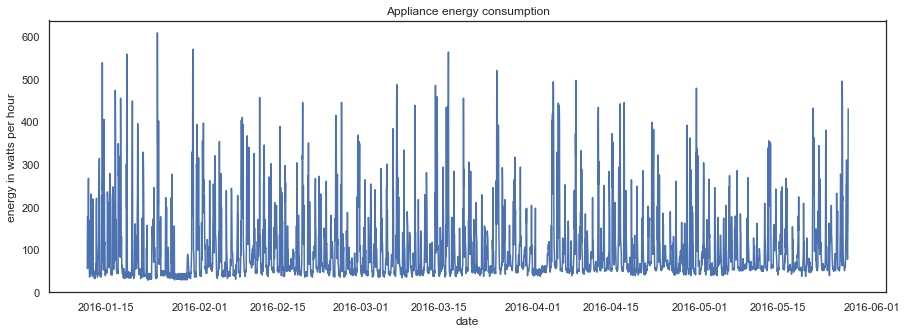

In [10]:
sns.set(rc={'figure.figsize':(15,5)}, style='white')
ax=sns.lineplot(data=edata, x='date', y='appl')
ax.set_ylabel('energy in watts per hour')
ax.set_title('Appliance energy consumption')
plt.show()

In [11]:
color_list= ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

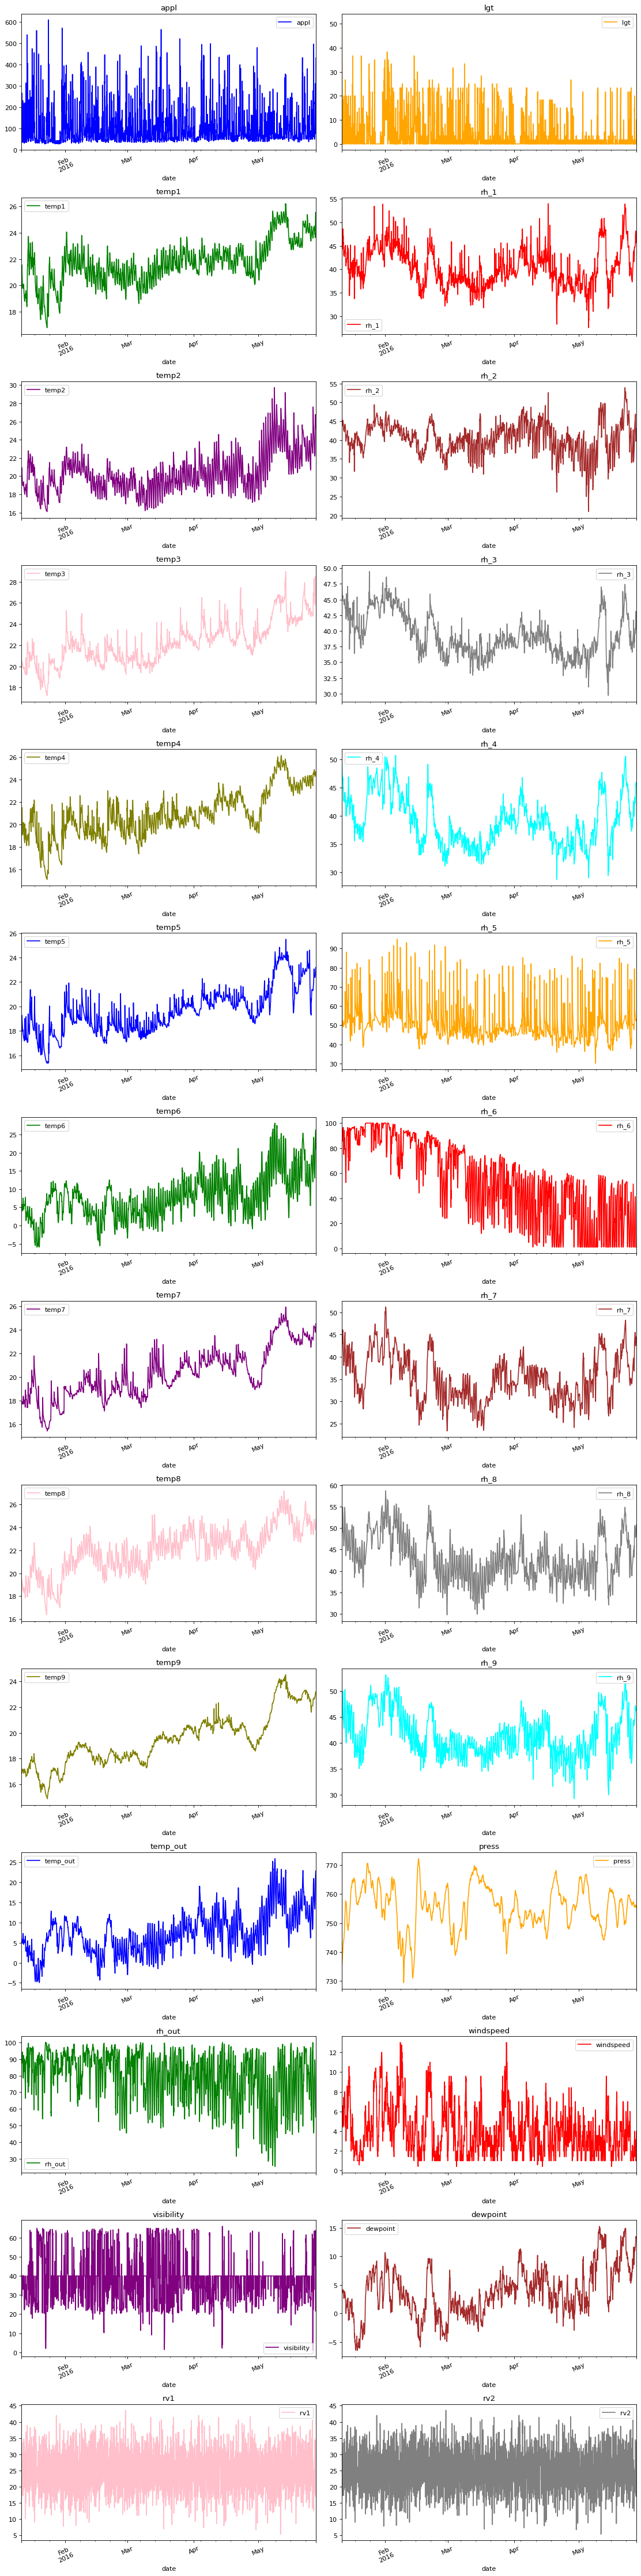

In [16]:
def Visualize(edata):
    features=list(edata.select_dtypes(include=[np.number]).columns.values)
    feature_size= len(features)
    fig, axes= plt.subplots(nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor='w', edgecolor='k')
    
    for i in range(feature_size):
        key= features[i]
        c=color_list[i % (len(color_list))]
        t_data=edata[key]
        t_data.head()
        ax=t_data.plot(ax=axes[i // 2, i % 2], color=c, title='{}'.format(key), rot=25,)
        ax.legend([key])
        plt.tight_layout()
        
Visualize(edata)
        

In [8]:
#running adfuller test
for i in range(len(edata.columns)):
    result= adfuller(edata[edata.columns[i]])
    
    if result[1]> 0.05:
        print('{}- Series is not Stationary'.format(edata.columns[i]))
    else:
        print('{}- Series is Stationary'.format(edata.columns[i]))

appl- Series is Stationary
lgt- Series is Stationary
temp1- Series is not Stationary
rh_1- Series is Stationary
temp2- Series is not Stationary
rh_2- Series is Stationary
temp3- Series is not Stationary
rh_3- Series is Stationary
temp4- Series is not Stationary
rh_4- Series is Stationary
temp5- Series is not Stationary
rh_5- Series is Stationary
temp6- Series is Stationary
rh_6- Series is not Stationary
temp7- Series is not Stationary
rh_7- Series is Stationary
temp8- Series is Stationary
rh_8- Series is Stationary
temp9- Series is not Stationary
rh_9- Series is Stationary
temp_out- Series is Stationary
press- Series is Stationary
rh_out- Series is Stationary
windspeed- Series is Stationary
visibility- Series is Stationary
dewpoint- Series is Stationary
rv1- Series is Stationary
rv2- Series is Stationary


In [9]:
#perfroming grangercausuality tests
max_lags=8
y='appl'

In [10]:
for i in range(len(edata.columns)-1):
    results= grangercausalitytests(edata[[y,edata.columns[i+1]]], max_lags, verbose=False)
    p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
    print('Column - {} : P_values - {}'.format(edata.columns[i+1], p_values))

Column - lgt : P_values - [0.1451, 0.0005, 0.0001, 0.0002, 0.0001, 0.0001, 0.0006, 0.0012]
Column - temp1 : P_values - [0.2272, 0.0238, 0.0025, 0.0013, 0.0003, 0.0006, 0.0001, 0.0002]
Column - rh_1 : P_values - [0.6989, 0.0012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - temp2 : P_values - [0.0653, 0.0399, 0.0699, 0.1679, 0.1941, 0.1999, 0.0156, 0.0]
Column - rh_2 : P_values - [0.0231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - temp3 : P_values - [0.4947, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - rh_3 : P_values - [0.617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - temp4 : P_values - [0.6215, 0.0254, 0.0339, 0.0094, 0.0164, 0.0216, 0.0397, 0.0047]
Column - rh_4 : P_values - [0.7711, 0.4626, 0.0333, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - temp5 : P_values - [0.375, 0.3035, 0.2825, 0.5269, 0.5924, 0.6757, 0.2565, 0.3229]
Column - rh_5 : P_values - [0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0001]
Column - temp6 : P_values - [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - rh_6 : P_values - [0.0

In [11]:
edata_in= edata[['appl','rh_2','rh_5','temp6','rh_6','temp_out','windspeed','rh_out']]

In [12]:
edata_in

,appl,rh_2,rh_5,temp6,rh_6,temp_out,windspeed,rh_out
date,,,,,,,,
2016-01-11 17:00:00,55.000000,44.626528,55.116667,6.586667,84.260000,6.308333,6.166667,92.000000
2016-01-11 18:00:00,176.666667,44.438889,54.977778,6.180000,87.204444,5.941667,5.416667,91.583333
2016-01-11 19:00:00,173.333333,46.061667,55.869861,5.857361,88.131389,6.000000,6.000000,89.750000
2016-01-11 20:00:00,125.000000,45.632639,74.027778,5.469444,86.933889,6.000000,6.000000,87.583333
2016-01-11 21:00:00,103.333333,44.961111,69.037778,5.578889,86.129444,5.833333,6.000000,87.416667
...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,101.666667,41.205054,53.052222,25.567222,1.000000,21.916667,2.000000,59.000000
2016-05-27 15:00:00,76.666667,41.041238,52.368611,26.279444,1.000000,22.216667,2.000000,57.333333
2016-05-27 16:00:00,135.000000,41.736190,52.094444,26.138889,1.000000,22.883333,2.416667,55.000000


In [13]:
e_train = edata_in[:int(0.7*(len(edata_in)))]
e_test = edata_in[int(0.7*(len(edata_in))):]

In [14]:
e_train.shape

(2303, 8)

In [15]:
e_test.shape

(987, 8)

In [16]:
model= VAR(e_train, freq='1H')
for i in range(48):
    results=model.fit(i+1)
    print('Order= ', i+1)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)

Order=  1
AIC:  12.085982222455073
BIC:  12.265561031502985
Order=  2
AIC:  10.279923848517043
BIC:  10.619250000731215
Order=  3
AIC:  10.043988227873744
BIC:  10.543176436736111
Order=  4
AIC:  9.92410078826424
BIC:  10.583265901155707
Order=  5
AIC:  9.900792767446111
BIC:  10.720049765861278
Order=  6
AIC:  9.864420058126925
BIC:  10.843884057889278
Order=  7
AIC:  9.856162603463881
BIC:  10.995948854941403
Order=  8
AIC:  9.84900125618003
BIC:  11.149225144501255
Order=  9
AIC:  9.843114195165029
BIC:  11.303891240435544
Order=  10
AIC:  9.851817941545113
BIC:  11.473263799064485
Order=  11
AIC:  9.841933067517989
BIC:  11.624163527997158
Order=  12
AIC:  9.84797195858427
BIC:  11.791102948363369
Order=  13
AIC:  9.861053379765117
BIC:  11.965200961031737
Order=  14
AIC:  9.865996554711332
BIC:  12.131276925719249
Order=  15
AIC:  9.885174190997118
BIC:  12.311703686285448
Order=  16
AIC:  9.88183873330807
BIC:  12.469733823920887
Order=  17
AIC:  9.895973402059132
BIC:  12.645350

In [17]:
model.select_order(48).summary()

,AIC,BIC,FPE,HQIC
0,29.57,29.59,6.960e+12,29.58
1,12.15,12.33,1.894e+05,12.22
2,10.34,10.68,3.091e+04,10.46
3,10.10,10.61*,2.442e+04,10.29
4,9.984,10.65,2.169e+04,10.23*
5,9.958,10.79,2.113e+04,10.26
6,9.925,10.92,2.044e+04,10.29
7,9.916,11.07,2.026e+04,10.34
8,9.908,11.23,2.009e+04,10.39
9,9.900,11.38,1.993e+04,10.44


In [18]:
model= VAR(e_train, freq='1H')
results=model.fit(3) #from the summary of lags

In [19]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Aug, 2022
Time:                     22:56:15
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    10.5432
Nobs:                     2300.00    HQIC:                   10.2260
Log likelihood:          -37459.1    FPE:                    23017.2
AIC:                      10.0440    Det(Omega_mle):         21110.1
--------------------------------------------------------------------
Results for equation appl
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               97.201574        21.765022            4.466           0.000
L1.appl              0.452639         0.021016           21.537           0.000
L1.rh_2             -9.974265         1.945992           -5.126  

In [20]:
lag=results.k_ar

In [21]:
results.forecast(e_train.values[-lag:], steps=5)

array([[130.49082498,  43.43127794,  49.73662819,   9.40037396,
         33.66757279,   9.85458705,   4.18763988,  71.3964173 ],
       [105.02936914,  43.58879605,  50.65142136,   8.64234612,
         38.84349693,   9.0416778 ,   3.94376524,  76.14423602],
       [ 97.84352035,  43.82889698,  50.82596263,   8.08671667,
         42.1066529 ,   8.43745128,   3.79718574,  79.50266933],
       [ 86.36517502,  43.93049914,  51.31951259,   7.7443606 ,
         44.32137097,   8.0305141 ,   3.72449227,  81.23365325],
       [ 81.64062829,  43.86230205,  51.65024769,   7.62151717,
         45.62256919,   7.79171236,   3.71936188,  81.90721235]])

In [22]:
e_test[0:5]

,appl,rh_2,rh_5,temp6,rh_6,temp_out,windspeed,rh_out
date,,,,,,,,
2016-04-16 16:00:00,441.666667,47.129722,47.183611,9.675556,45.418889,9.638333,4.166667,75.916667
2016-04-16 17:00:00,251.666667,52.584444,50.153333,10.627778,39.926667,8.016667,3.000000,84.916667
2016-04-16 18:00:00,136.666667,48.463333,49.552222,10.106389,33.338333,8.683333,2.583333,81.583333
2016-04-16 19:00:00,113.333333,45.718889,48.442222,8.638889,36.724444,8.466667,2.416667,81.833333
2016-04-16 20:00:00,101.666667,44.919444,47.301111,7.374167,38.133889,7.791667,2.583333,84.250000


In [23]:
edata_coeff= pd.DataFrame([results.params['appl'], results.pvalues['appl']]).T

In [24]:
edata_coeff

,appl,appl
const,97.201574,7.971299e-06
L1.appl,0.452639,6.955524e-103
L1.rh_2,-9.974265,2.966836e-07
L1.rh_5,-0.508463,7.351956e-02
L1.temp6,-0.068253,9.841021e-01
L1.rh_6,0.074691,8.836747e-01
L1.temp_out,-3.526866,4.789269e-01
L1.windspeed,1.774986,4.234677e-01
L1.rh_out,0.010440,9.884718e-01
L2.appl,0.241487,2.047621e-25


In [25]:
edata_coeff.columns= ['coeff', 'pval']

In [26]:
edata_coeff.query('pval <0.05')
np.where(edata_coeff['pval'] < 0.05,1,0)

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0])

In [27]:
edata_coeff['valid']=np.where(edata_coeff['pval'] < 0.05,1,0)

In [28]:
edata_coeff

,coeff,pval,valid
const,97.201574,7.971299e-06,1
L1.appl,0.452639,6.955524e-103,1
L1.rh_2,-9.974265,2.966836e-07,1
L1.rh_5,-0.508463,7.351956e-02,0
L1.temp6,-0.068253,9.841021e-01,0
L1.rh_6,0.074691,8.836747e-01,0
L1.temp_out,-3.526866,4.789269e-01,0
L1.windspeed,1.774986,4.234677e-01,0
L1.rh_out,0.010440,9.884718e-01,0
L2.appl,0.241487,2.047621e-25,1


In [29]:
#coeff_arr=np.multiply(edata_coeff['coeff'], edata_coeff['valid'])[1:].values
coeff_arr=edata_coeff['coeff'][1:].values

In [30]:
coeff_arr.shape

(24,)

In [31]:
coeff_arr

array([ 4.52639307e-01, -9.97426476e+00, -5.08462686e-01, -6.82534411e-02,
        7.46911798e-02, -3.52686589e+00,  1.77498553e+00,  1.04399118e-02,
        2.41487422e-01,  1.12519094e+01, -5.14635619e-01,  8.90458996e+00,
        2.85959124e-01, -5.95855491e+00, -2.32380501e+00, -6.11712469e-01,
       -6.52168799e-02, -1.97395612e+00,  3.20709244e-01, -1.12915345e+00,
       -8.83697899e-02,  2.11573087e+00,  1.65234979e+00,  3.27558341e-01])

In [32]:
e_train[-lag:]

,appl,rh_2,rh_5,temp6,rh_6,temp_out,windspeed,rh_out
date,,,,,,,,
2016-04-16 13:00:00,233.333333,41.155000,47.297222,14.338889,11.764444,10.633333,5.000000,70.000000
2016-04-16 14:00:00,241.666667,42.702778,47.076667,12.772222,10.533889,10.766667,4.583333,69.166667
2016-04-16 15:00:00,113.333333,43.682222,47.004444,10.418056,24.532222,10.633333,4.416667,68.000000


In [33]:
in_arr= e_train[-lag:][::-1].stack().to_frame().T.values

In [34]:
in_arr.shape

(1, 24)

In [35]:
in_arr

array([[113.33333333,  43.68222222,  47.00444444,  10.41805556,
         24.53222222,  10.63333333,   4.41666667,  68.        ,
        241.66666667,  42.70277778,  47.07666667,  12.77222222,
         10.53388889,  10.76666667,   4.58333333,  69.16666667,
        233.33333333,  41.155     ,  47.29722222,  14.33888889,
         11.76444444,  10.63333333,   5.        ,  70.        ]])

In [36]:
np.dot(in_arr, coeff_arr)+edata_coeff['coeff'][:1].values

array([130.49082498])